# Creation of our own model

In [1]:
from carRecognition import display_bounding_boxes

import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.nn.functional as F
import matplotlib.pylab as plt
import numpy as np

import os
import json
import torch
from torch.utils.data import Dataset, DataLoader, random_split
# from PIL import Image
import torchvision.transforms as transforms
import pandas as pd

import cv2
torch.manual_seed(2)

# https://www.kaggle.com/datasets/sshikamaru/car-object-detection/data

In [2]:
# Global variables

NEW_WIDTH = 338
NEW_HEIGHT = 190

# NEW_HEIGHT = 190
# NEW_WIDTH = 338

# cv2     : [height, width, c]
# pytorch : [channels, height, width]

In [3]:
class CarRecognitionDataset(Dataset):
    def __init__(self, images_dir, csv_annotations, transform=None):
        self.images_dir = images_dir
        self.annotations = pd.read_csv(csv_annotations)
        self.transform = transform

    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.images_dir, self.annotations.iloc[index, 0])
        image = cv2.imread(img_path)
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # for display
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # enough to have 1 channel...
        # image = image[:,:,:3] # removing alpha cannal if it exists
        # must be (c, height, width)
        # note : trasnform.ToTensor() does the permute() alone
        y = torch.tensor(self.annotations.iloc[index, 1:5]) # 1:5 for bounding box coord
        y = y/2 # change to ratio

        image = self.transform(image) # transform has to resize


        return image, y

In [4]:
def iou_bboxes(outputs: torch.Tensor, labels: torch.Tensor, smooth=1e-6):
    # outputs et labels sont supposés être de forme [batch_size, 4] avec 4 pour les coordonnées [x_min, y_min, x_max, y_max]
    
    # Calcul des coordonnées de l'intersection
    x1 = torch.max(outputs[:, 0], labels[:, 0])
    y1 = torch.max(outputs[:, 1], labels[:, 1])
    x2 = torch.min(outputs[:, 2], labels[:, 2])
    y2 = torch.min(outputs[:, 3], labels[:, 3])
    
    # Calcul de l'aire de l'intersection
    intersection = torch.clamp(x2 - x1, min=0) * torch.clamp(y2 - y1, min=0)
    
    # Calcul de l'aire de chaque boîte
    area_output = (outputs[:, 2] - outputs[:, 0]) * (outputs[:, 3] - outputs[:, 1])
    area_label = (labels[:, 2] - labels[:, 0]) * (labels[:, 3] - labels[:, 1])
    
    # Calcul de l'aire de l'union
    union = area_output + area_label - intersection + smooth  # Ajout de smooth pour éviter la division par zéro
    
    # Calcul de l'IoU
    iou = (intersection + smooth) / union
    return iou.mean()  # Retourne l'IoU moyen pour le batch

In [5]:
dataset = CarRecognitionDataset(csv_annotations='data/train_boxes.csv', images_dir='data/train/',
                                 transform = transforms.Compose([
                                     transforms.ToTensor(),
                                     transforms.Resize((NEW_HEIGHT, NEW_WIDTH))
                                 ]))

In [6]:
train_size = int(0.90 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, drop_last=True)

In [7]:
def train(model, criterion, train_loader, test_loader, optimizer, epochs=10):
    i = 0
    output = {'training_loss': [], 'test_accuracy': []}  
    
    for epoch in range(epochs):
        print(str(epoch) + " / " + str(epochs))
        for i, (image, box) in enumerate(train_loader):
            image=image.float()
            box=box.float()
            optimizer.zero_grad()
            z = model(image)
            loss = criterion(z, box)
            loss.backward()
            optimizer.step()
            output['training_loss'].append(loss.data.item())
    
    return output

In [8]:
sobel3_verti = torch.tensor([[-1., -2., -1.],
                             [0., 0., 0.],
                             [1., 2., 1.]]) # "vertical", Sobel filter, from top to bottom
# aa = sobel3_verti * -1
sobel3_horiz = torch.transpose(sobel3_verti, 0, 1)

class Sobel(nn.Module):
    def __init__(self):
        super(Sobel, self).__init__()
        self.sobel_verti = sobel3_verti.view(1, 1, 3, 3)
        self.sobel_horiz = sobel3_horiz.view(1, 1, 3, 3)

    def forward(self, x, threshold = 1.0):
        sob_vert = F.conv2d(x, self.sobel_verti, groups=1)
        sob_hori = F.conv2d(x, self.sobel_horiz, groups=1)
        vert_sq = torch.mul(sob_vert, sob_vert)
        hori_sq = torch.mul(sob_hori, sob_hori)
        filtered = torch.sqrt( torch.add( vert_sq, hori_sq ) ) # sqrt(verti² + horiz²)

        thresholded = torch.where(filtered < threshold, torch.tensor(0.0), filtered)
        return thresholded
        

# model = Sobel()
# a = model(img, 1.6)
# plt.imshow(a.permute(1,2,0))

In [9]:
## ONGOING CAR DETECTION MODEL NOVEMBER 3rd 2024
class CarNet(nn.Module):
    def __init__(self, in_size, threshold = 0.5):
        super(CarNet, self).__init__()
        self.threshold = threshold
        self.dynamic_input = 167*93*16 # size * conv1 output

        self.sobel = Sobel()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.fc1 = nn.Linear(self.dynamic_input, 128)
        self.fc2 = nn.Linear(128, 4)

    def forward(self, img):

        # print("Input : ", end="")
        # print(img.shape)

        x = self.sobel(img, self.threshold)
        # print("Sobel : ", end="")
        # print(x.shape)
        # here : 336, 188       (actually 188, 336)
        x = F.relu(self.conv1(x))
        # print("Relu : ", end="")
        # print(x.shape)
        # 334, 186
        x = self.pool1(x)
        # print("Pool : ", end="")
        # print(x.shape)
        # 167, 93

        x = x.view(-1, self.dynamic_input)
        x = self.fc1(x)
        x = self.fc2(x)
        return x
    
# shape '[-1, 505344]' is invalid for input of size 7951872

In [10]:
## ONGOING CAR DETECTION MODEL NOVEMBER 3rd 2024
class CarNetSimple(nn.Module):
    def __init__(self, threshold = 0.5):
        super(CarNetSimple, self).__init__()
        self.threshold = threshold
        self.dynamic_input = 336*188 # size * conv1 output

        self.sobel = Sobel()
        self.fc1 = nn.Linear(self.dynamic_input, 4)


    def forward(self, img):

        x = self.sobel(img, self.threshold)

        x = x.view(-1, self.dynamic_input)
        x = self.fc1(x)

        return x
    
# shape '[-1, 505344]' is invalid for input of size 7951872

In [12]:
import torch.optim as optim

# images INITIAL shape : 676 x 380

learning_rate = 0.001
epochs = 800
# model = CarNet(1, threshold=1.0)
model = CarNet(1)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

output=train(model, criterion, train_loader, val_loader, optimizer, epochs)




0 / 800
1 / 800
2 / 800
3 / 800
4 / 800
5 / 800
6 / 800
7 / 800
8 / 800
9 / 800
10 / 800
11 / 800
12 / 800
13 / 800
14 / 800
15 / 800
16 / 800
17 / 800
18 / 800
19 / 800
20 / 800
21 / 800
22 / 800
23 / 800
24 / 800
25 / 800
26 / 800
27 / 800
28 / 800
29 / 800
30 / 800
31 / 800
32 / 800
33 / 800
34 / 800
35 / 800
36 / 800
37 / 800
38 / 800
39 / 800
40 / 800
41 / 800
42 / 800
43 / 800
44 / 800
45 / 800
46 / 800
47 / 800
48 / 800
49 / 800
50 / 800
51 / 800
52 / 800
53 / 800
54 / 800
55 / 800
56 / 800
57 / 800
58 / 800
59 / 800
60 / 800
61 / 800
62 / 800
63 / 800
64 / 800
65 / 800
66 / 800
67 / 800
68 / 800
69 / 800
70 / 800
71 / 800
72 / 800
73 / 800
74 / 800
75 / 800
76 / 800
77 / 800
78 / 800
79 / 800
80 / 800
81 / 800
82 / 800
83 / 800
84 / 800
85 / 800
86 / 800
87 / 800
88 / 800
89 / 800
90 / 800
91 / 800
92 / 800
93 / 800
94 / 800
95 / 800
96 / 800
97 / 800
98 / 800
99 / 800
100 / 800
101 / 800
102 / 800
103 / 800
104 / 800
105 / 800
106 / 800
107 / 800
108 / 800
109 / 800
110 / 800


In [13]:
model.eval()
total_iou = 0.0
num_batches = 0
transform = transforms.Compose([transforms.Resize((NEW_HEIGHT, NEW_WIDTH))])

with torch.no_grad():
    for images, labels in val_loader:

        img = transform(images)
        predictions = model(img)
        # predictions = pred.numpy()
        
        # Calcul de l'exactitude (accuracy)
        # _, predicted = torch.max(predictions, 1)
        # correct += (predicted == labels).sum().item()
        
        # Calcul de l'IoU pour le batch
        batch_iou = iou_bboxes(predictions, labels)
        total_iou += batch_iou.item()
        num_batches += 1

mean_iou = total_iou / num_batches
print(f"Mean IoU: {mean_iou}")


Mean IoU: 0.055127894819928996


done
torch.Size([1, 190, 338])
tensor([[153.1096,  89.2830, 201.0005, 109.2954]])


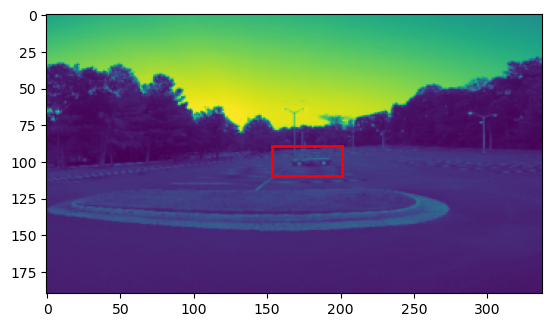

In [ ]:
model.eval()
for name, param in model.named_parameters():
    param.requires_grad = False
print("done")

image_path = 'data/test/vid_5_400.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

transform = transforms.Compose([transforms.ToTensor(), # -> [C, H, W]
                                transforms.Resize((NEW_HEIGHT, NEW_WIDTH))])
img = transform(image)
pred = model(img)
print(pred)
display_bounding_boxes(img.permute(1,2,0).numpy(), pred) # -> [H, W, C]

tensor([[111.7579,  97.7267, 163.0819, 119.9084]])


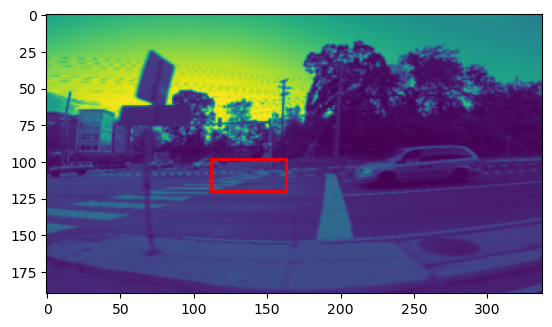

In [15]:
image_path = 'data/test/vid_5_27480.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

transform = transforms.Compose([transforms.ToTensor(), # -> [C, H, W]
                                transforms.Resize((NEW_HEIGHT, NEW_WIDTH))])
img = transform(image)

pred = model(img)
print(pred)
display_bounding_boxes(img.permute(1,2,0).numpy(), pred) # -> [H, W, C]

tensor([[142.6195,  93.7618, 200.1185, 114.3654]])


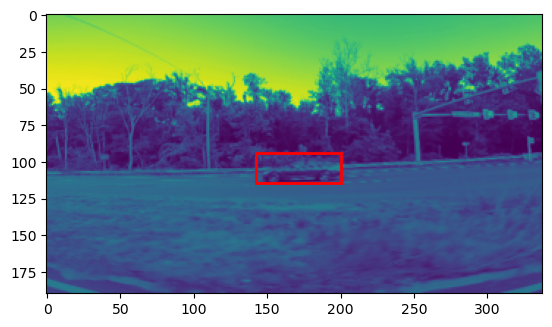

In [16]:
image_path = 'data/train/vid_4_600.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

transform = transforms.Compose([transforms.ToTensor(), # -> [C, H, W]
                                transforms.Resize((NEW_HEIGHT, NEW_WIDTH))])
img = transform(image)

pred = model(img)
print(pred)
display_bounding_boxes(img.permute(1,2,0).numpy(), pred) # -> [H, W, C]

tensor([[138.9033,  89.8734, 197.4703, 114.6909]])


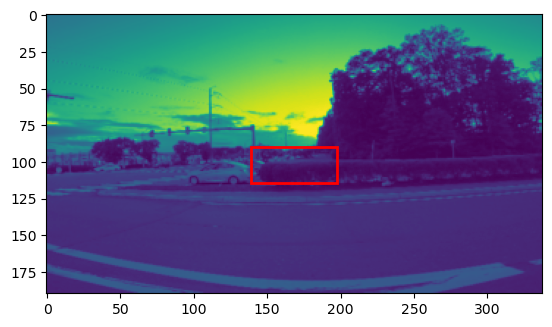

In [17]:
image_path = 'data/train/vid_4_30440.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

transform = transforms.Compose([transforms.ToTensor(), # -> [C, H, W]
                                transforms.Resize((NEW_HEIGHT, NEW_WIDTH))])
img = transform(image)

pred = model(img)
print(pred)
display_bounding_boxes(img.permute(1,2,0).numpy(), pred) # -> [H, W, C]

tensor([[125.9744,  89.0409, 173.2267, 111.5366]])


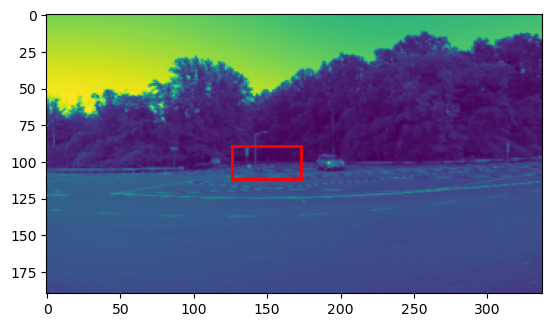

In [18]:

image_path = 'data/train/vid_4_980.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

transform = transforms.Compose([transforms.ToTensor(), # -> [C, H, W]
                                transforms.Resize((NEW_HEIGHT, NEW_WIDTH))])
img = transform(image)

pred = model(img)
print(pred)
display_bounding_boxes(img.permute(1,2,0).numpy(), pred) # -> [H, W, C]

In [ ]:
sobel3_verti = torch.tensor([[-1., -2., -1.],
                             [0., 0., 0.],
                             [1., 2., 1.]]) # "vertical", Sobel filter, from top to bottom
# aa = sobel3_verti * -1
sobel3_horiz = torch.transpose(sobel3_verti, 0, 1)

## MAKING SOBEL CLASS WORK

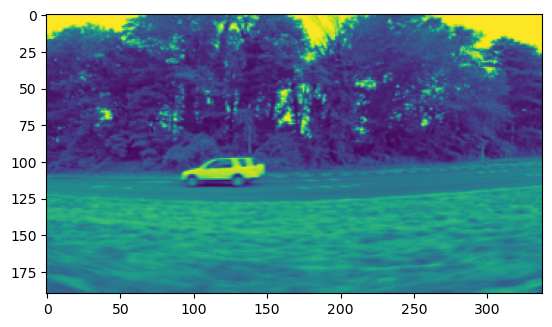

In [50]:
image_path = 'data/train/vid_4_3140.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # for display

#image = image[:,:,:]

transform = transforms.Compose([transforms.ToTensor(), # -> [C, H, W]
                                transforms.Resize((NEW_HEIGHT, NEW_WIDTH))])
img = transform(image)
plt.imshow(img.permute(1,2,0))

In [51]:
img.shape

torch.Size([1, 190, 338])

In [12]:
# it WORKS, now do 3 channel

# first lets make it 1 channel, we'll see how it scores, if it scores bad, we'll see 3 channels

In [14]:
class Sobel(nn.Module):
    def __init__(self):
        super(Sobel, self).__init__()
        self.sobel_verti = sobel3_verti.view(1, 1, 3, 3)
        self.sobel_horiz = sobel3_horiz.view(1, 1, 3, 3)

    def forward(self, x, threshold = 0.5):
        sob_vert = F.conv2d(x, self.sobel_verti, groups=1)
        sob_hori = F.conv2d(x, self.sobel_horiz, groups=1)
        vert_sq = torch.mul(sob_vert, sob_vert)
        hori_sq = torch.mul(sob_hori, sob_hori)
        filtered = torch.sqrt( torch.add( vert_sq, hori_sq ) ) # sqrt(verti² + horiz²)

        thresholded = torch.where(filtered < threshold, torch.tensor(0.0), filtered)
        return thresholded
        

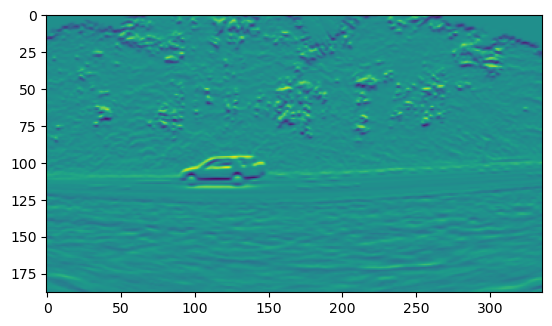

In [17]:
# controled conv1
nb_channels = 1

weights = sobel3_verti.view(1, 1, 3, 3)#.repeat(nb_channels, 1, 1, 1)
Gx = F.conv2d(img, weights, groups=1)
plt.imshow(Gx.permute(1,2,0))




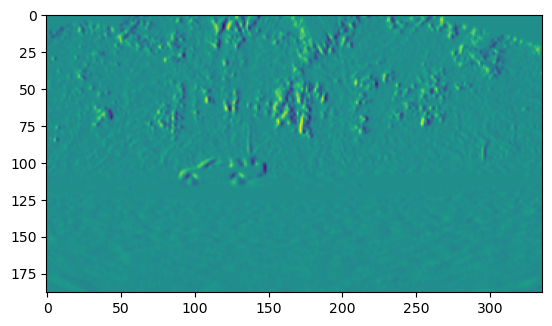

In [82]:
weights = sobel3_horiz.view(1, 1, 3, 3)#.repeat(nb_channels, 1, 1, 1)
Gy = F.conv2d(img, weights, groups=1)
plt.imshow(Gy.permute(1,2,0))


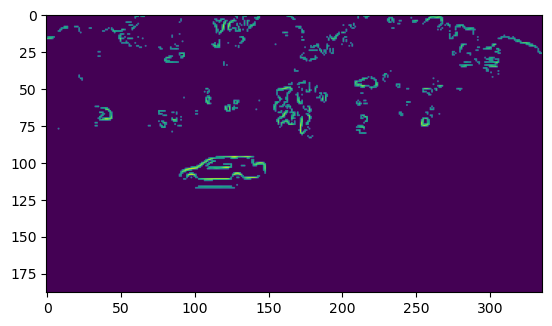

In [18]:
model = Sobel()
a = model(img, 1.6)
plt.imshow(a.permute(1,2,0))

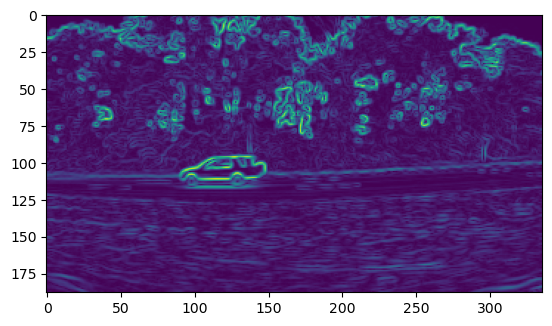

In [86]:
finx = torch.mul(Gx, Gx)
finy = torch.mul(Gy, Gy)
s = torch.add(finx, finy)
fin = torch.sqrt(s)
plt.imshow(fin.permute(1,2,0))

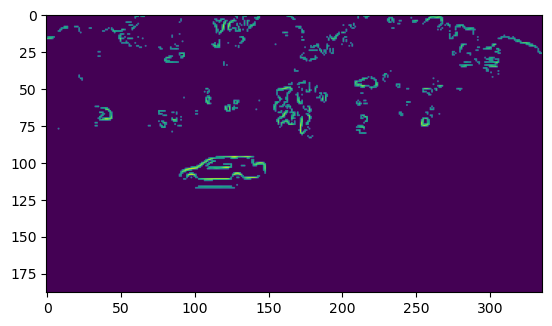

In [87]:
# do the threshold
shape = fin.shape
flat = fin.flatten()
threshold = 1.6

for i in range(len(flat)):
    if flat[i] < threshold : flat[i] = 0

param = flat.view(shape)
plt.imshow(param.permute(1,2,0))

## END SOBEL CLASS

## HANDS-ON MODEL MANIP

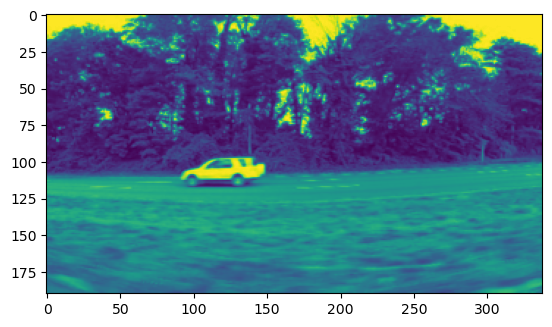

In [16]:
image_path = 'data/train/vid_4_3140.jpg'
image = cv2.imread(image_path)
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # for display
image = image[:,:,0]

transform = transforms.Compose([transforms.ToTensor(), # -> [C, H, W]
                                transforms.Resize((NEW_HEIGHT, NEW_WIDTH))])
img = transform(image)
plt.imshow(img.permute(1,2,0))

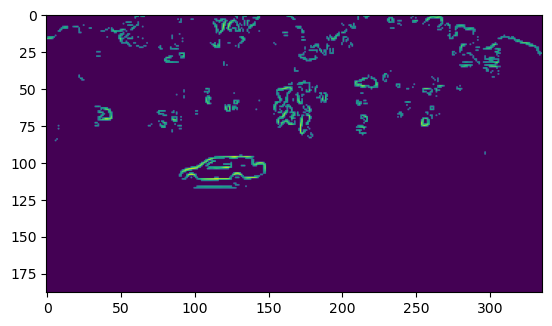

In [159]:
model = Sobel()
mod = model(img, threshold=1.5)
plt.imshow(mod.permute(1,2,0))

In [178]:
conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=1)
x = conv1(mod)

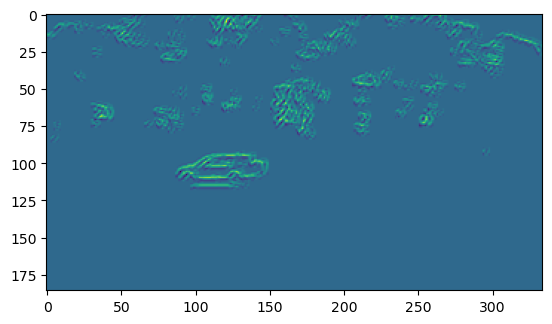

In [179]:
plt.imshow(x.detach().permute(1,2, 0).numpy()[:,:,0])

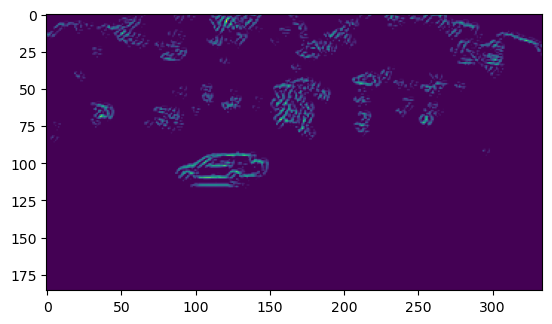

In [180]:
tik = F.relu(x)
plt.imshow(tik.detach().permute(1,2, 0).numpy()[:,:,0])

In [181]:
pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
tok = pool1(tik)

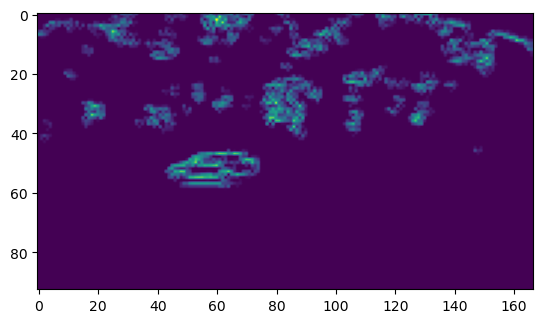

In [182]:
plt.imshow(tok.detach().permute(1,2, 0).numpy()[:,:,0])